In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import HMC, MCMC, NUTS, SVI, Trace_ELBO
from src.data.preprocessing import load_thickness_time_series
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [2]:
Nr = np.arange(1, 6).tolist()
radius = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df_kuaq = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "KUAQ_filtered.csv")
df_kuaq.Time = pd.to_datetime(df_kuaq.Time)
# df_mass = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "mass_time_series.csv")
df_height = load_thickness_time_series(
    PROJECT_ROOT / "data" / "processed" / "1900_2020_mean_thickness.mat"
)
df = pd.merge(df_height, df_kuaq, how="inner")

height = df.Thickness.values
uplift = df.Up.values

df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [3]:
# 68.704665, -33.214577 further back
# 68.645056, -33.029416 near front
station_coordinates = [68.58700000, -33.05270000]
glacier_coordinates = [68.704665, -33.214577]
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(
    hlove, nlove, glacier_coordinates, station_coordinates, arsurf=30e3 * 30e3
)
print(gf)

5.6081345318527523e-05


In [4]:
# change some numbers in earth model:
df_em["rigidity"][0] = 4e10
df_em["rigidity"][1] = 5e10

hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(
    hlove, nlove, glacier_coordinates, station_coordinates, arsurf=30e3 * 30e3
)
print(gf)

9.118324238840856e-05


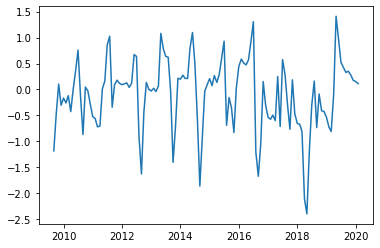

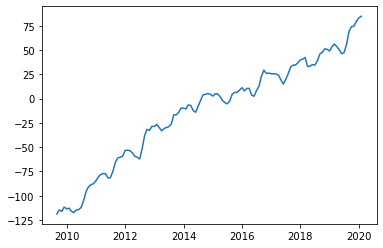

In [4]:
plt.plot(df.Time, df.Thickness)
plt.show()
plt.plot(df.Time, df.Up)
plt.show()

In [5]:
radius = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity_init = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

In [6]:
np.std(rigidity_init)

76695331452.70317

In [7]:
from pyro.infer import config_enumerate


@config_enumerate
def model(height, obs=None, df_em=None):
    E_L = pyro.sample("E_L", dist.Normal(0.0, 1.0))
    # df_em["rigidity"][0] = pyro.sample("rigidity", dist.Normal(torch.ones
    rigidity = pyro.sample(
        "rigidity",
        dist.Normal(
            torch.tensor(rigidity_init),
            np.std(rigidity_init) * torch.ones(5),
        ),
    )
    df_em["rigidity"] = rigidity
    # Draw upper mantle elasticity
    # E_UM = pyro.sample("E_UM", dist.Normal(0.0, 1.0))

    # Draw lower mantle elasticity
    # E_LM = pyro.sample("E_LM", dist.Normal(0.0, 1.0))

    # Draw mass change with time
    # m = pyro.sample("m", dist.Normal(torch.zeros(128), torch.ones(128)))

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(0.1))
    sigma_gf = 1

    with pyro.plate("data"):
        # Draw Love Numbers
        hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)

        # Draw Greens Function
        gf = pyro.sample(
            "gf",
            dist.Normal(
                greens_function(
                    hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000]
                ),
                sigma_gf,
            ),
        )

        # Draw target
        w = pyro.sample("w", dist.Normal(gf * height, sigma_w), obs=obs)

In [8]:
X_train = torch.tensor(height).float()
y_train = torch.tensor(uplift).float()

In [9]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=5, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

# Show summary of inference results
mcmc.summary()

Warmup:   0%|                                                                                                         | 0/6 [00:00, ?it/s]
KeyboardInterrupt



# Train_model.py

def premis_train(m, x=1, n=128, obs=None) -> np.ndarray:
    """Probabilistic model for uplift rates. This is the main model.
    Args:
        m (np.ndarray): mass time-series data
        s (int, optional): number of stations. Defaults to 2.
        n (int, optional): spherical harmonic degree. Defaults to 128.
        obs (_type_, optional): observed gnss station uplift rates. Defaults to None.

    Returns:
        np.ndarray: predicted uplift
    """

    #  could add dists over mu and sigmas
    #  sigma = pyro.sample("sigma", dist.HalfCauchy(5.))

    # Draw lithospheric elasticity
    E_L = pyro.sample("E_L", dist.Normal(0.0, 1.0))

    # Draw upper mantle elasticity
    E_UM = pyro.sample("E_UM", dist.Normal(0.0, 1.0))

    # Draw lower mantle elasticity
    E_LM = pyro.sample("E_LM", dist.Normal(0.0, 1.0))

    # Draw mass change with time
    # m = pyro.sample("m", dist.Normal(torch.zeros(128), torch.ones(128)))

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(0.1))
    sigma_gf = 1

    station_coordinates = [68.58700000, -33.05270000]  # [lat, lon]
    glacier_coordinates = [68.645056, -33.029416]  # [lat, lon]

    with pyro.plate("data"):
        # Draw Love Numbers
        hlove, nlove = torch.tensor(compute_love_numbers())

        # Draw Greens Function
        gf = pyro.sample(
            "gf",
            dist.Normal(
                greens_function(hlove, nlove, glacier_coordinates, station_coordinates),
                sigma_gf,
            ),
        )

        # Draw target
        w = pyro.sample("w", dist.Normal(gf * m, sigma_w), obs=obs)

    return w


def taboo(j: int, e_l: float, e_um: float, e_lm: float) -> np.ndarray:
    """temporary taboo function for running pyro model
    Args:
        j (int): _description_
        e_l (float): _description_
        e_um (float): _description_
        e_lm (float): _description_

    Returns:
        np.ndarray: _description_
    """

    love_numbers = np.random.randint(j)
    return love_numbers


# if __name__ == '__main__':
#     # X = load data
#     # obs = ob
#     _ = premis_train()
